# Chat Bot Evaluation as Multi-agent Simulation

When building a chat bot, such as a customer support assistant, it can be hard to properly evalute your bot's performance. It's time-consuming to have to manually interact with it intensively for each code change.

One way to make the evaluation process easier and more reproducible is to simulate a user interaction.

With LangGraph, it's easy to set this up. Below is an example of how to create a "virtual user" to simulate a conversation.

The overall simulation looks something like this:

![diagram](./img/virtual_user_diagram.png)

First, we'll set up our environment.

In [1]:
%pip install -U langgraph langchain langchain_openai --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
embedchain 0.1.93 requires langchain-openai<0.0.6,>=0.0.5, but you have langchain-openai 0.0.8 which is incompatible.
crewai 0.19.0 requires langchain-openai<0.0.6,>=0.0.5, but you have langchain-openai 0.0.8 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

True

## 1. Define Chat Bot

Next, we will define our chat bot. For this notebook, we assume the bot's API accepts a list of messages and responds with a message. If you want to update this, all you'll have to change is this section and the "get_messages_for_agent" function in 
the simulator below.

The implementation within `my_chat_bot` is configurable and can even be run on another system (e.g., if your system isn't running in python).

In [6]:
from typing import List

from openai import AzureOpenAI

azure_openai = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),  
    api_version=os.getenv("OPENAI_API_VERSION"),
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    )

# This is flexible, but you can define your agent here, or call your agent API here.
def my_chat_bot(messages: List[dict]) -> dict:
    system_message = {
        "role": "system",
        "content": "You are a customer support agent for an airline.",
    }
    messages = [system_message] + messages
    completion = azure_openai.chat.completions.create(
        messages=messages, model="gpt-35-turbo"
    )
    return completion.choices[0].message.model_dump()

In [7]:
my_chat_bot([{"role": "user", "content": "hi!"}])

{'content': 'Hello! How can I assist you today?',
 'role': 'assistant',
 'function_call': None,
 'tool_calls': None}

## 2. Define Simulated User

We're now going to define the simulated user. 
This can be anything we want, but we're going to build it as a LangChain bot.

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import chain
from langchain_openai import AzureChatOpenAI
import os

system_prompt_template = """You are a customer of an airline company. \
You are interacting with a user who is a customer support person. \

{instructions}

When you are finished with the conversation, respond with a single word 'FINISHED'"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_template),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
instructions = """Your name is Harrison. You are tyring to get a refund for the trip you took to Alaska. \
You want them to give you ALL the money back. \
This trip happened 5 years ago."""

prompt = prompt.partial(name="Harrison", instructions=instructions)

DEPLOYMENT_NAME="gpt-35-turbo"
MODEL_NAME = "gpt-35-turbo"

model = AzureChatOpenAI(
    azure_deployment=DEPLOYMENT_NAME, 
    model_name=MODEL_NAME, 
    openai_api_version=os.getenv("OPENAI_API_VERSION"),
    temperature=0)

simulated_user = prompt | model

In [9]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="Hi! How can I help you?")]
simulated_user.invoke({"messages": messages})

AIMessage(content='Hi Harrison! How can I assist you today?', response_metadata={'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}})

## 3. Define the Agent Simulation

The code below creates a LangGraph workflow to run the simulation. The main components are:

1. The two nodes: one for the simulated user, the other for the chat bot.
2. The graph itself, with a conditional stopping criterion.

Read the comments in the code below for more information.


**Nodes**

First, we define the nodes in the graph. These should take in a list of messages and return a list of messages to ADD to the state.
These will be thing wrappers around the chat bot and simulated user we have above.

**Note:** one tricky thing here is which messages are which. Because both the chat bot AND our simulated user are both LLMs, both of them will resond with AI messages. Our state will be a list of alternating Human and AI messages. This means that for one of the nodes, there will need to be some logic that flips the AI and human roles. In this example, we will assume that HumanMessages are messages from the simulated user. This means that we need some logic in the simulated user node to swap AI and Human messages.

First, let's define the chat bot node

In [10]:
from langchain.adapters.openai import convert_message_to_dict
from langchain_core.messages import AIMessage


def chat_bot_node(messages):
    # Convert from LangChain format to the OpenAI format, which our chatbot function expects.
    messages = [convert_message_to_dict(m) for m in messages]
    # Call the chat bot
    chat_bot_response = my_chat_bot(messages)
    # Respond with an AI Message
    return AIMessage(content=chat_bot_response["content"])

Next, let's define the node for our simulated user. This will involve a little logic to swap the roles of the messages.

In [11]:
def _swap_roles(messages):
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            new_messages.append(HumanMessage(content=m.content))
        else:
            new_messages.append(AIMessage(content=m.content))
    return new_messages


def simulated_user_node(messages):
    # Swap roles of messages
    new_messages = _swap_roles(messages)
    # Call the simulated user
    response = simulated_user.invoke({"messages": new_messages})
    # This response is an AI message - we need to flip this to be a human message
    return HumanMessage(content=response.content)

**Edges**

We now need to define the logic for the edges. The main logic occurs after the simulated user goes, and it should lead to one of two outcomes:

- Either we continue and call the customer support bot
- Or we finish and the conversation is over

So what is the logic for the conversation being over? We will define that as either the Human chatbot responds with `FINISHED` (see the system prompt) OR the conversation is more than 6 messages long (this is an arbitrary number just to keep this example short).

In [12]:
def should_continue(messages):
    if len(messages) > 6:
        return "end"
    elif messages[-1].content == "FINISHED":
        return "end"
    else:
        return "continue"

**Graph**

We can now define the graph that sets up the simulation!

In [13]:
from langgraph.graph import END, MessageGraph


graph_builder = MessageGraph()
graph_builder.add_node("user", simulated_user_node)
graph_builder.add_node("chat_bot", chat_bot_node)
# Every response from  your chat bot will automatically go to the
# simulated user
graph_builder.add_edge("chat_bot", "user")
graph_builder.add_conditional_edges(
    "user",
    should_continue,
    # If the finish criteria are met, we will stop the simulation,
    # otherwise, the virtual user's message will be sent to your chat bot
    {
        "end": END,
        "continue": "chat_bot",
    },
)
# The input will first go to your chat bot
graph_builder.set_entry_point("chat_bot")
simulation = graph_builder.compile()

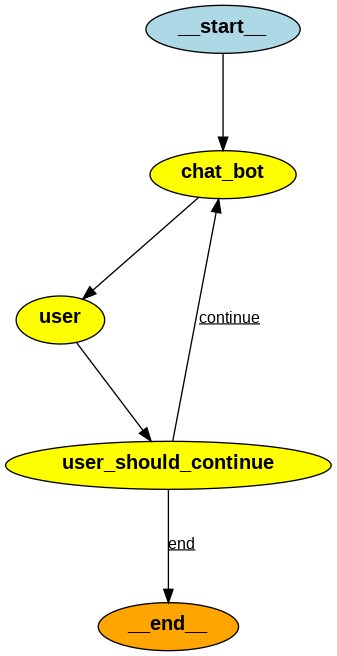

In [15]:
from IPython.display import Image
Image(simulation.get_graph().draw_png())

## 4. Run Simulation

Now we can evaluate our chat bot! We can invoke it with empty messages (this will simulate letting the chat bot start the initial conversation)

In [16]:
for chunk in simulation.stream([]):
    # Print out all events aside from the final end chunk
    if END not in chunk:
        print(chunk)
        print("----")

{'chat_bot': AIMessage(content='Hello! Thank you for contacting us. How can I assist you today?')}
----
{'user': HumanMessage(content='Hello, I would like to request a refund for a trip I took to Alaska with your airline company 5 years ago. I believe I am entitled to a full refund due to some issues I experienced during the trip.')}
----
{'chat_bot': AIMessage(content="I'm sorry to hear that you experienced issues during your trip to Alaska. However, our airline's policy typically only allows for refunds within a specific time frame after the date of travel. Since your trip was 5 years ago, it's unlikely that we would be able to provide a refund at this point. Is there anything else I can assist you with regarding a more recent travel issue or concern?")}
----
{'user': HumanMessage(content='I understand your policy, but I believe my situation warrants an exception. The issues I experienced during the trip were significant and I believe I am entitled to a full refund. I would like to s